In [10]:
# Tutorial code of 1-D GAN
# http://blog.naver.com/atelierjpro/220984758512
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import tensorflow as tf


In [22]:
sess = tf.InteractiveSession()
mu = 0.5
sigma=0.1
num_bins = 100
num_samples = 100000

class GenerativeNetwork:
    dim_z=1
    dim_g=1
    
    def __init__(self):
        rand_uni = tf.random_uniform_initializer(-1e1,1e1)
        self.z_input = tf.placeholder(tf.float32,shape = [None,self.dim_z],name = "z-input")
        self.W0 = tf.Variable(rand_uni([self.dim_z,self.dim_g]))
        self.b0 = tf.Variable(rand_uni([self.dim_g]))
        self.g = tf.nn.sigmoid(tf.matmul(self.z_input,self.W0)+self.b0)
        
    def generate(self,z_i):
        z_i = np.reshape(z_i,[-1,self.dim_z])
        g_i = sess.run([self.g],feed_dict={self.z_input : z_i})
        return g_i[0]


class Discriminator:
    dim_x = 1
    dim_d = 1
    num_hidden_neurons = 10
    learning_rate = 0.1
    x_input = tf.placeholder(tf.float32,shape=[None,dim_x],name="x_input")
    d_target = tf.placeholder(tf.float32,shape=[None,dim_d],name="d_target")

    rand_uni = tf.random_uniform_initializer(-1e-2,1e-2)

    W0 = tf.Variable(rand_uni([dim_x,num_hidden_neurons]))
    b0 = tf.Variable(rand_uni([num_hidden_neurons]))
    W1 = tf.Variable(rand_uni([num_hidden_neurons,dim_d]))
    b1 = tf.Variable(rand_uni([dim_d]))

    
    def __init__(self):
        
        self.d = self.getNetwork(self.x_input)
        
        self.loss = tf.losses.mean_squared_error(self.d,self.d_target)
        
        self.opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
    def getNetwork(self,input):
        
        temp = tf.nn.tanh(tf.matmul(input,self.W0)+self.b0)
        return tf.nn.sigmoid(tf.matmul(temp,self.W1)+self.b1)
    
    def discriminate(self,x_i):
        d_i = sess.run([self.d],feed_dict={self.x_input:x_i})
        return d_i[0]
    
    def train(self,x_i,d_i):
        error,_ = sess.run([self.loss,self.opt],feed_dict={self.x_input:x_i,self.d_target:d_i})
        return error

def draw(x,z,g,D):
    #draw histogram
    bins = np.linspace(0,1,num_bins)
    px, _ = np.histogram(x,bins=bins, density = True)
    pz, _ = np.histogram(z,bins=bins, density = True)
    pg,_ = np.histogram(g,bins=bins, density= True)

    v = np.linspace(0,1,len(px))

    v_i = np.reshape(v,(len(v),D.dim_x))
    db = D.discriminate(v_i)
    db = np.reshape(db,len(v))

    l = plt.plot(v,px,'b--',linewidth=1)
    l = plt.plot(v,pz,'r--',linewidth=1)
    l = plt.plot(v,pg,'g--',linewidth=1)
    l = plt.plot(v,db,'k--',linewidth=1)


    plt.title('1D GAN Test')
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    plt.show()


Hello! GAN!
Pre-train Discriminator
0.255409
0.264453
0.25069
0.250586
0.250658
0.250621
0.250658
0.250629
0.250658
0.250633


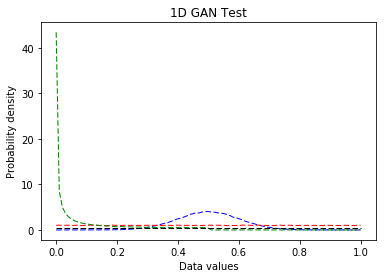

Train Generator
0.695543 1.38497
3.72074 0.353992
3.62623 0.361828
3.57648 0.368626
3.54775 0.374816
3.53585 0.380569
3.53767 0.386051
3.55078 0.391407
3.57261 0.396776
3.60469 0.402258
3.6477 0.40798
3.70057 0.414125
3.76193 0.420869
3.82711 0.428375
3.88843 0.436745
3.93939 0.445951
3.97277 0.455891
3.98854 0.466362
3.99017 0.47717
3.97925 0.488171
3.95747 0.499244
3.93208 0.510265
3.89246 0.521183
3.85134 0.531909
3.81491 0.542396
3.76716 0.552673
3.71569 0.562667
3.65138 0.572327
3.57033 0.581511
3.46516 0.590075
3.35702 0.597936
3.25192 0.605014


In [ ]:
print("Hello! GAN!")

x = np.random.normal(mu,sigma,num_samples)
z = np.random.uniform(0,1,num_samples)
g = np.ndarray(num_samples)

G = GenerativeNetwork()
D = Discriminator()

tf.global_variables_initializer().run()

# for i in range(0,num_samples,1):
#     z_i = np.reshape(z[i],G.dim_z)
#     g[i] =G.generate(z_i)
x_i = np.reshape(x,(num_samples,D.dim_x))
z_i = np.reshape(z,(num_samples,G.dim_z))
g_i = G.generate(z_i)
g = np.reshape(g_i,(num_samples))

d_x_i = np.ndarray(shape=(num_samples,D.dim_x))
d_x_i.fill(1.0)

d_g_i = np.ndarray(shape = (num_samples,D.dim_x))
d_g_i.fill(0.0)

# Not a good way to train.
# TODO: shuffle samples
print("Pre-train Discriminator")
for tr in range(0,500,1):
    D.train(x_i,d_x_i)
    D.train(z_i,d_g_i) # z_i -> g_i
    if tr % 100 ==0:
        print(D.train(x_i,d_x_i))
        print(D.train(g_i,d_g_i))

draw(x,z,g,D)
# GAN algorithm

# Training Generator
D_from_g = D.getNetwork(G.g)

# Optimization of Generator
loss_g = tf.reduce_mean(-tf.log(D_from_g))
opt_g = tf.train.GradientDescentOptimizer(1e-3).minimize(loss_g)

# Optimization of Discriminator
loss_d = tf.reduce_mean(-tf.log(D.d)-tf.log(1.0-D_from_g))
opt_d = tf.train.GradientDescentOptimizer(1e-3).minimize(loss_d)

# Train both
frame_num = 0

print("Train Generator")
for tr in range(0,10000,1):
    # Generate g from z again to respond the training of Generator
    g_i = G.generate(z_i)
    g = np.reshape(g_i,(num_samples))
    
    # train Discriminator from real/generated samples
    D.train(x_i,d_x_i)
    D.train(g_i,d_g_i)
    
    # GAN update
    sess.run([loss_g, opt_g],feed_dict={G.z_input:z_i})
    sess.run([loss_d, opt_d],feed_dict={D.x_input:x_i,G.z_input:z_i})
    
    if tr%100==0:
        error_g,_ = sess.run([loss_g, opt_g],feed_dict={G.z_input:z_i})
        error_d,_ = sess.run([loss_d, opt_d],feed_dict={D.x_input:x_i,G.z_input:z_i})
        print(error_g,error_d)
        
    
draw(x,z,g,D)

# print("Frame num",frame_num)


"""
filename = "./capture/" + str(frame_num).zfill(5) + ".png"
plt.savefig(filename)
frame_num += 1
"""